<a href="https://colab.research.google.com/github/LeonelCS5/CSCI166/blob/main/Copy_of_c166DeepQLearning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install gymnasium

In [ ]:
import random, time
from collections import deque, namedtuple

import gymnasium as gym
import numpy as np
import tensorflow as tf
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))
print("Num CPUs Available: ", len(tf.config.list_physical_devices('CPU')))

from tqdm.auto import tqdm

n_episodes = 50  # play 1000 games
eps = 1.0  # exploration rate, probability of choosing random action
eps_decay = 0.9975  # eps gets multiplied by this number each epoch...
min_eps = 0.1  # ...until this minimum eps is reached
gamma = 0.95  # discount
max_memory_size = 10000  # size of the replay memory
batch_size = 16  # batch size of the neural network training
min_length = 160  # minimum length of the replay memory for training, before it reached this length, no gradient updates happen
memory_parts = [
    "state",
    "action",
    "next_state",
    "reward",
    "done",
]  # nice names for the part of replay memory, otherweise the names are 0-5

Num GPUs Available:  0
Num CPUs Available:  1


In [ ]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


# Learning A Model

In [ ]:
Memory = namedtuple("Memory", memory_parts)  # a single entry of the memory replay


class ReplayMemory:
    def __init__(self, max_length=None):
        self.max_length = max_length
        self.memory = deque(maxlen=max_length)

    def store(self, data):
        self.memory.append(data)

    def _sample(self, k):
        return random.sample(self.memory, k)

    def structured_sample(self, k):
        batch = self._sample(k)
        result = {}
        for i, part in enumerate(memory_parts):
            result[part] = np.array([row[i] for row in batch])

        return result

    def __len__(self):
        return len(self.memory)

In [ ]:
model = tf.keras.Sequential(
    [
        tf.keras.layers.Input(shape=(4,)),  # Define input shape with Input layer
        tf.keras.layers.Dense(128, activation="relu"),
        tf.keras.layers.Dense(64, activation="relu"),
        tf.keras.layers.Dense(32, activation="relu"), # added
        tf.keras.layers.Dense(16, activation="relu"),
        tf.keras.layers.Dense(2, activation="linear"),  # 2 actions: go left or go right
    ]
)
model.compile(
    loss=tf.keras.losses.MeanSquaredError(),
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
)

In [ ]:
env = gym.make("CartPole-v1")
replay_memory = ReplayMemory(max_length=max_memory_size)

for episode in tqdm(range(n_episodes)):  # tqdm makes a nice proress bar
    state, _ = env.reset()
    done = False

    while not done:
        if random.random() < eps:
            action = env.action_space.sample()  # random action
        else:
            action = model.predict(state[np.newaxis, :], verbose=False).argmax()  # best action according to the model

        next_state, reward, done, _, _ = env.step(action)
        memory = Memory(state, action, next_state, reward, done)
        replay_memory.store(memory)

        if len(replay_memory) >= min_length:
            batch = replay_memory.structured_sample(batch_size)  # get samples from the replay memory

            target_batch = batch["reward"] + gamma * model.predict(batch["next_state"], verbose=False).max(axis=1) * (
                1 - batch["done"]
            )  # R(s, a) + γ·maxₐ N(s') if not a terminal state, otherwise R(s, a)
            targets = model.predict(batch["state"], verbose=False)
            targets[
                range(batch_size), batch["action"]
            ] = target_batch  # set the target for the action that was done and leave the outputs of other 3 actions as they are

            model.fit(batch["state"], targets, verbose=False, batch_size=batch_size)  # train for one epoch

        state = next_state
    if episode % 100 == 0:
      save_path = '/content/drive/My Drive/my_QmodelB_{}iterations.keras'.format(episode)
      print (save_path)
      model.save(save_path)
    eps = max(min_eps, eps * eps_decay)
save_path = '/content/drive/My Drive/my_QmodelB_{}iterations.keras'.format(episode)
print (save_path)
model.save(save_path)

  0%|          | 0/50 [00:00<?, ?it/s]

/content/drive/My Drive/my_QmodelB_0iterations.keras
/content/drive/My Drive/my_QmodelB_49iterations.keras


In [ ]:
eps_decay = 0.9975
min_eps = 0.01
eps = 1.0
for i in range(1000):
  eps = max(min_eps, eps * eps_decay)
  if (i % 10==0):
    print (i, eps)

print(eps)

0 0.9975
10 0.972841184720621
20 0.9487919505650338
30 0.9253372283118559
40 0.9024623212601521
50 0.8801528960204993
60 0.8583949735337022
70 0.8371749203115317
80 0.8164794398939969
90 0.7962955645177996
100 0.7766106469907487
110 0.7574123527670455
120 0.7386886522184717
130 0.7204278130966384
140 0.7026183931815739
150 0.6852492331120414
160 0.668309449393098
170 0.6517884275765086
180 0.6356758156097455
190 0.6199615173494054
200 0.6046356862349768
210 0.5896887191189979
220 0.5751112502497359
230 0.5608941454026172
240 0.5470284961567343
250 0.5335056143128392
260 0.5203170264493284
270 0.5074544686128074
280 0.49490988113990647
290 0.48267540360710603
300 0.4707433699054044
310 0.45910630343674297
320 0.4477569124291788
330 0.43668808536786924
340 0.42589288653900503
350 0.4153645516839004
360 0.40509648376051655
370 0.39508224880976317
380 0.3853155719239871
390 0.375790333315123
400 0.3665005644800414
410 0.3574404444606915
420 0.34860429619669614
430 0.33998658296811235
440 0

# Test Learned Models

In [ ]:
## Choose Model
version = 1
models = [(100, '1-5OnAiomUcoOgnpzvnC1x744w0Um8HI4'), (200, '1-6ATw7_LiBPHySnVKFel-w2pFgf4E3Hu')]

!gdown {models[version][1]}
save_path=f'my_QmodelB_{models[version][0]}iterations.keras'
print(save_path)

Downloading...
From: https://drive.google.com/uc?id=1-6ATw7_LiBPHySnVKFel-w2pFgf4E3Hu
To: /content/my_QmodelB_200iterations.keras
100% 148k/148k [00:00<00:00, 7.64MB/s]
my_QmodelB_200iterations.keras


In [ ]:
import matplotlib.pyplot as plt
import gymnasium as gym
import tensorflow as tf

from tensorflow.keras.models import load_model

model = load_model(save_path, compile=False)
model.compile(
    loss=tf.keras.losses.MeanSquaredError(),
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
)

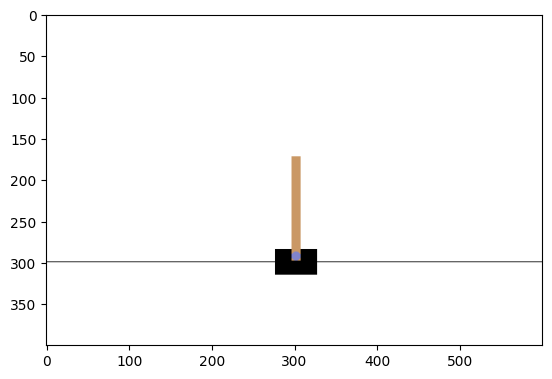

action=1, total_reward=1.0


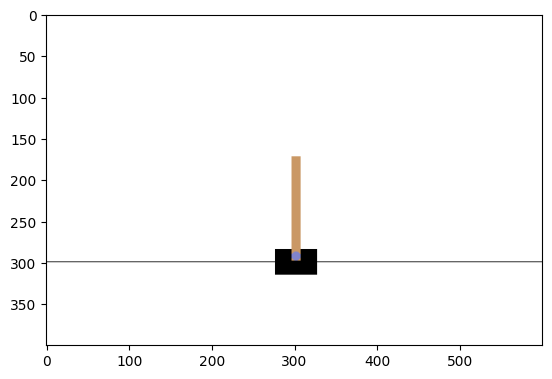

In [ ]:
env = gym.make("CartPole-v1", render_mode="rgb_array")
state, _ = env.reset()
done = False
total_reward = 0
state_image=env.render()
plt.imshow(state_image)
plt.show()

state_image=env.render()
action = model.predict(state[np.newaxis, :], verbose=False).argmax(axis=1)[0]
state, reward, done, _, _ = env.step(action)
total_reward += reward
print (f"{action=}, {total_reward=}")
state_image=env.render()
plt.imshow(state_image)
plt.show()

In [ ]:
env = gym.make("CartPole-v1", render_mode="human")

state, _ = env.reset()
done = False
total_reward = 0

while not done and total_reward < 500:  # force end the game after 500 time steps because the model is too good!
    env.render()
    action = model.predict(state[np.newaxis, :], verbose=False).argmax(axis=1)[0]
    state, reward, done, _, _ = env.step(action)
    total_reward += reward

env.close()
print (f"{total_reward=}")

total_reward=351.0


In [ ]:
env.close()

The first step I took was running the game with the default hyperparameters to test the running time. However, running 1000 epochs was taking a significant amount of time, so I reduced the number of episodes to 100, achieving a total reward of 255. Even then, the training time was still quite long, so I further reduced the episodes to 50, with a total reward of 204.

In my next experiment, I modified the neural network structure. Specifically, I added an additional hidden layer increasing the number of neurons. This was done to allow the network to learn more complex patterns. This change resulted in an increase in total reward from 204 to 237.

Next, I experimented with epsilon decay, which controls how quickly the agent shifts from exploring to exploiting learned strategies. I slowed down the decay by changing the epsilon decay rate from 0.9975 to 0.9995, allowing the agent to explore longer. However, this led to a decrease in total reward to 222. I then adjusted the epsilon decay to 0.998, which resulted in a slight improvement to 228. After these trials, I concluded that the original decay rate of 0.9975 was optimal for this setup.

Following this, I adjusted the learning rate, reducing it from 0.01 to 0.001. This slower learning rate allowed the model to take smaller steps and converge more steadily toward an optimal solution. The result was an increase in total reward to 248, although the training took slightly longer.

I then experimented with adjusting the max memory size. I tested both increasing and decreasing the memory size, but in both cases, the total reward decreased. Similarly, changing other parameters didn’t result in significant improvements.

Finally, I tried increasing the number of episodes to 70, hoping for a higher total reward. However, this actually resulted in a decrease to 230. I reverted to 50 episodes and achieved a final total reward of 351, which was the best result from my exploration.

